In [1]:
import warnings
warnings.filterwarnings('ignore')

## Petrophysics calculation

In [2]:
import lasio
las=lasio.read('well-1.las') 

#convert the las file to pandas dataframe, this will automatically retain the logname and made the depth as index column
well=las.df()
print (well)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB
DEPTH                                                       
3001.0  9.984  148.500  80.875  0.722  0.991  0.43701  2.170
3001.5  9.938  148.625  80.875  0.718  1.026  0.47705  2.176
3002.0  9.914  146.125  80.625  0.714  0.990  0.45947  2.166
3002.5  9.859  145.375  82.625  0.715  0.953  0.47754  2.158
3003.0  9.914  145.125  81.938  0.709  0.900  0.45508  2.156
...       ...      ...     ...    ...    ...      ...    ...
4458.0  8.484  109.000  79.812  1.122  1.744  0.33252  2.316
4458.5  8.469  109.438  82.312  1.112  1.972  0.34082  2.326
4459.0  8.484  109.562  77.188  1.092  1.959  0.35693  2.316
4459.5  8.461  110.750  75.250  1.079  1.746  0.37256  2.311
4460.0  8.469  110.938  75.188  1.067  1.625  0.36768  2.307

[2919 rows x 7 columns]


In [3]:
KujungFM=well.loc[3337.79:3751.5]
print (KujungFM)

         CALI       DT      GR    ILD   MSFL  NPHI_LS   RHOB
DEPTH                                                       
3338.0  8.617  123.625  88.812  1.006  1.292  0.48193  2.264
3338.5  8.562  116.875  79.500  1.182  1.258  0.46924  2.320
3339.0  8.594  100.000  68.562  1.417  1.250  0.37354  2.408
3339.5  8.492   83.938  51.500  1.742  1.430  0.21143  2.562
3340.0  8.297   65.750  33.844  2.174  7.311  0.13428  2.668
...       ...      ...     ...    ...    ...      ...    ...
3749.5  8.555  130.625  85.000  0.773  0.873  0.43115  2.184
3750.0  8.648  130.875  87.500  0.772  0.891  0.43164  2.170
3750.5  8.680  130.875  86.250  0.775  1.158  0.44092  2.178
3751.0  8.727  129.375  89.188  0.773  1.072  0.42285  2.184
3751.5  8.633  129.500  89.688  0.772  1.035  0.40430  2.191

[828 rows x 7 columns]


In [4]:
#this code is adapted from andy mcdonald

def shale_volume(gamma_ray, gamma_ray_max, gamma_ray_min): #specify the arguments
    vshale = (gamma_ray - gamma_ray_min) / (gamma_ray_max - gamma_ray_min) #use the argument to the equation using math operators
    return round(vshale, 4)

def density_porosity(input_density, matrix_density, fluid_density):
    denpor = (matrix_density - input_density) / (matrix_density - fluid_density)
    return round(denpor, 4)

In [5]:
mDens= 2.65
fDens= 1
KujungFM['VSHALE']=shale_volume(KujungFM['GR'], KujungFM['GR'].quantile(q=0.99),
                             KujungFM['GR'].quantile(q=0.01))
KujungFM['PHI']=density_porosity(KujungFM['RHOB'], mDens, fDens)
KujungFM.head()

,CALI,DT,GR,ILD,MSFL,NPHI_LS,RHOB,VSHALE,PHI
DEPTH,,,,,,,,,
3338.0,8.617,123.625,88.812,1.006,1.292,0.48193,2.264,0.8678,0.2339
3338.5,8.562,116.875,79.500,1.182,1.258,0.46924,2.320,0.7119,0.2000
3339.0,8.594,100.000,68.562,1.417,1.250,0.37354,2.408,0.5289,0.1467
3339.5,8.492,83.938,51.500,1.742,1.430,0.21143,2.562,0.2433,0.0533
3340.0,8.297,65.750,33.844,2.174,7.311,0.13428,2.668,-0.0522,-0.0109


### Calculate RW and SW

**Apparent water formation resistivity using Hingle method**
<img src=https://github.com/partsolco/python-geo-20feb2021/blob/main/images/rw.PNG?raw=true>

**SW:**
<img src=https://github.com/partsolco/python-geo-20feb2021/blob/main/images/sw_archie.png?raw=true>

In [6]:
def rw_app(porosity, archieA, archieM, rt):
    rw= ((porosity**archieM)*(rt/archieA))
    return rw

def sw_archie(porosity, rt, rw, archieA, archieM, archieN):
    sw = ((archieA / (porosity ** archieM)) * (rw/rt))**(1/archieN)
    return sw

archieA= 1
archieM= 2
archieN= 2

In [7]:
KujungFM['rw']=rw_app(KujungFM['NPHI_LS'],archieA,archieM, KujungFM['ILD'])
KujungFM['SW'] =sw_archie(KujungFM['NPHI_LS'],KujungFM['ILD'], KujungFM['rw'], archieA,archieM, archieN)

KujungFM.head()

,CALI,DT,GR,ILD,MSFL,NPHI_LS,RHOB,VSHALE,PHI,rw,SW
DEPTH,,,,,,,,,,,
3338.0,8.617,123.625,88.812,1.006,1.292,0.48193,2.264,0.8678,0.2339,0.233650,1.0
3338.5,8.562,116.875,79.500,1.182,1.258,0.46924,2.320,0.7119,0.2000,0.260260,1.0
3339.0,8.594,100.000,68.562,1.417,1.250,0.37354,2.408,0.5289,0.1467,0.197717,1.0
3339.5,8.492,83.938,51.500,1.742,1.430,0.21143,2.562,0.2433,0.0533,0.077872,1.0
3340.0,8.297,65.750,33.844,2.174,7.311,0.13428,2.668,-0.0522,-0.0109,0.039200,1.0


In [8]:
KujungFM.describe()

,CALI,DT,GR,ILD,MSFL,NPHI_LS,RHOB,VSHALE,PHI,rw,SW
count,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,8.280000e+02
mean,8.588909,118.736715,76.343841,1.109170,1.743801,0.381769,2.225851,0.659101,0.257057,0.154674,1.000000e+00
std,0.340040,12.152890,13.450552,0.408286,3.261412,0.053883,0.071534,0.225129,0.043354,0.032237,4.316309e-17
min,7.680000,57.625000,17.641000,0.563000,0.460000,0.119630,1.875000,-0.323400,-0.041800,0.039200,1.000000e+00
25%,8.344000,110.531000,69.188000,0.864750,1.119000,0.349120,2.188000,0.539300,0.238800,0.133070,1.000000e+00
50%,8.539000,119.375000,79.750000,1.061000,1.343500,0.387700,2.230000,0.716100,0.254500,0.152117,1.000000e+00
75%,8.758000,128.031250,85.453500,1.267250,1.583000,0.419920,2.256000,0.811575,0.280000,0.173003,1.000000e+00
max,10.422000,156.250000,101.188000,6.004000,42.829000,0.486330,2.719000,1.074900,0.469700,0.343277,1.000000e+00


In [9]:
newKujungFM=KujungFM[['rw', 'SW']]
print (newKujungFM)


              rw   SW
DEPTH                
3338.0  0.233650  1.0
3338.5  0.260260  1.0
3339.0  0.197717  1.0
3339.5  0.077872  1.0
3340.0  0.039200  1.0
...          ...  ...
3749.5  0.143693  1.0
3750.0  0.143834  1.0
3750.5  0.150668  1.0
3751.0  0.138214  1.0
3751.5  0.126190  1.0

[828 rows x 2 columns]


## Data Handling

- ***explore the statistical information of the SW and RW log***
- ***compare the mean and the standard deviation of each log from the pandas result***
- ***visualize using histogram, boxplot, etc***

In [10]:
import pandas as pd
df = newKujungFM
print(df)

              rw   SW
DEPTH                
3338.0  0.233650  1.0
3338.5  0.260260  1.0
3339.0  0.197717  1.0
3339.5  0.077872  1.0
3340.0  0.039200  1.0
...          ...  ...
3749.5  0.143693  1.0
3750.0  0.143834  1.0
3750.5  0.150668  1.0
3751.0  0.138214  1.0
3751.5  0.126190  1.0

[828 rows x 2 columns]


In [11]:
print ('mean for all variables in df: \n' + str(df.mean())+'\n')
print ('median for all variables in df: \n' + str(df.median()))


mean for all variables in df: 
rw    0.154674
SW    1.000000
dtype: float64

median for all variables in df: 
rw    0.152117
SW    1.000000
dtype: float64


In [12]:
print ('range for variables rw & SW in df: \n' + str(df.max()-df.min())+'\n')
print ('variance for variables rw & SW in df: \n' + str(df.var())+'\n')
print ('standard deviation for variables rw & SW in df: \n' + str(df.std()))

range for variables rw & SW in df: 
rw    3.040771e-01
SW    1.110223e-16
dtype: float64

variance for variables rw & SW in df: 
rw    1.039209e-03
SW    1.863052e-33
dtype: float64

standard deviation for variables rw & SW in df: 
rw    3.223677e-02
SW    4.316309e-17
dtype: float64


In [13]:
print(df.describe())

               rw            SW
count  828.000000  8.280000e+02
mean     0.154674  1.000000e+00
std      0.032237  4.316309e-17
min      0.039200  1.000000e+00
25%      0.133070  1.000000e+00
50%      0.152117  1.000000e+00
75%      0.173003  1.000000e+00
max      0.343277  1.000000e+00


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


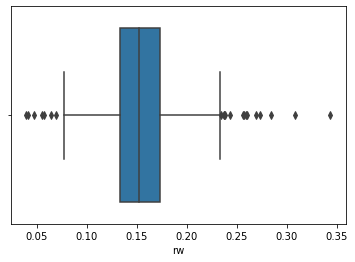

In [15]:
sns.boxplot(df['rw'])
plt.show()

In [16]:
print(df)

              rw   SW
DEPTH                
3338.0  0.233650  1.0
3338.5  0.260260  1.0
3339.0  0.197717  1.0
3339.5  0.077872  1.0
3340.0  0.039200  1.0
...          ...  ...
3749.5  0.143693  1.0
3750.0  0.143834  1.0
3750.5  0.150668  1.0
3751.0  0.138214  1.0
3751.5  0.126190  1.0

[828 rows x 2 columns]


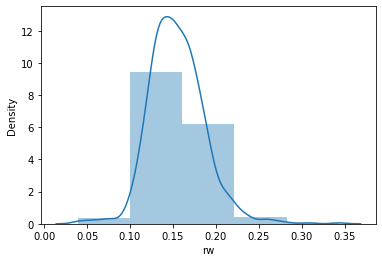

In [17]:
sns.distplot(df['rw'], bins=5)
plt.show()


In [18]:
X = df[['rw']]
y = df['SW']
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y)



LinearRegression()

In [19]:
df['Ypred'] = reg.predict(X)

df.head()

,rw,SW,Ypred
DEPTH,,,
3338.0,0.233650,1.0,1.0
3338.5,0.260260,1.0,1.0
3339.0,0.197717,1.0,1.0
3339.5,0.077872,1.0,1.0
3340.0,0.039200,1.0,1.0


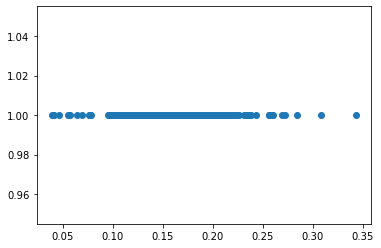

In [20]:
plt.figure()
plt.scatter(df.rw,df.SW)
plt.show()


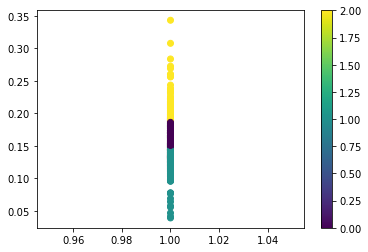

In [21]:
df.shape

from sklearn.cluster import KMeans
clus = df[['rw','SW']]
kmeans = KMeans(n_clusters=3, random_state=0).fit(clus)
df["clusters"]=kmeans.labels_

plt.figure()
plt.scatter(df.SW,df.rw, c=df.clusters)
plt.colorbar()
plt.show()


In [23]:
print(df[df['clusters']==2])


              rw        SW     Ypred  clusters
DEPTH                                         
3338.0  0.239912  0.997813  0.200256         2
3346.0  0.209618  0.989455  0.197018         2
3346.5  0.231203  1.032696  0.213770         2
3347.0  0.240021  1.059981  0.224340         2
3347.5  0.257909  1.072736  0.229281         2
...          ...       ...       ...       ...
3749.5  0.260938  1.100195  0.239918         2
3750.0  0.261387  1.100515  0.240042         2
3750.5  0.265063  1.096502  0.238488         2
3751.0  0.257047  1.102625  0.240860         2
3751.5  0.248511  1.108755  0.243234         2

[451 rows x 4 columns]


In [24]:
print(df.clusters.unique())

#inertia score determination
score = []
for k in range(2, 10):
 kmeans = KMeans(n_clusters=k)
 kmeans.fit_predict(clus)
 score.append(kmeans.inertia_) 

[2 0 1]


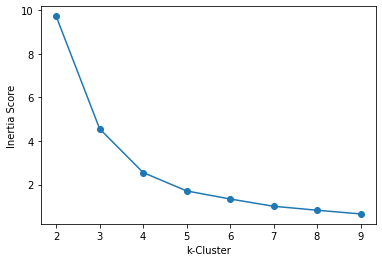

In [25]:
import numpy as np
#plotting elbow method
plt.figure()
plt.plot(np.arange(2,10), score)
plt.scatter(np.arange(2,10), score)
plt.xlabel("k-Cluster")
plt.ylabel("Inertia Score")
plt.show()
